# Red neuronal MLP
## Introducción y objectivo 
### Descipción del problema a resolver
Esta red consiste en predecir si una persona gana más de 50k anualmente basado en distintos datos que están expuestos en el datasest adult.csv.

### Porqué la elección del dataset
La razon de haber elegido este dataset, es porque me parecio un concepto interesante (mas no me sorprende) de que existan datos demográficos que denoten la cantidad monetaria que uno pueda llegar a generar en un año. Esto en cierta forma describe y hace ver la diferencia de posibilidades que existen en paises desarrollados contra los paises de tercer mundo.

Primero hacemos import de las librerias necesarias

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn
import matplotlib.pyplot as plt

2025-12-08 20:28:42.622361: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-08 20:28:42.622653: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-08 20:28:42.655674: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-08 20:28:43.393399: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

## Exploración de datos (EDA)
### Carga del dataset y visualización de los datos
Ahora, hacemos importación de los datos de entrenamiento y hacemos una impresion de las primeras 5 lineas solo para verificar vagemente el estado de lo mismos.

In [ ]:
df = pd.read_csv("datasets/adult.csv")
df.head(5)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


### Estadística descriptiva
Tambien encontramos cierta data informativa de los mismos. Vemos que tenemos un dataset de 48,842 datos y tenemos una cantidad de 37,155 datos que ganan menos de 50K y 11,687 que ganan mas que eso.

In [10]:
def print_category_counts(df, column):
    counts = df[column].value_counts()
    print(f"Conteo de columna {column}:")
    print(counts)

print("Total de datos:", len(df))
print_category_counts(df, 'income')

Total de datos: 48842
Conteo de columna income:
income
<=50K    37155
>50K     11687
Name: count, dtype: int64


### Identificación de desbalanceos o problemas
Al analizar la información, podemos ver que hay algunos datos de celdas vacias con un signo de interrogación. Para evitar cualquier problemática, se removerá este símbolo y se pondrá como vacío para tener la data más limpia.

También para tener algo más fácil de interpretar y utilizar, se hace un reemplazo de las categorias del output >50K y <=50K por 1 y 0 respectivamente.

## Preprocesamiento
### Limpieza de datos
Ahora con las anotaciones vistas en la sección anterior, procedemos a hacer una limpieza de los mismos. También se están quitando ciertas columnas que no se tomarán en cuenta para el análisis. Específicamente la columna fnlwgt, que no es un valor que nos esté aportando mucho y la columna 'relationship', que creo que es un poco redundante considerando que ya tenemos el estado civil registrado.

También establecemos los valores de tanto de X, que es la data menos las columnnas ignoradas y la columna de salida 'income' y la salida y es el income.

In [13]:
df = df.replace('?', np.nan).dropna()
df['income'] = df['income'].apply(lambda x: 1 if x == '>50K' else 0)

x = df.drop('income', axis=1).drop('fnlwgt', axis=1).drop('relationship', axis=1)
y = df['income']

### Normalización
Ahora hacemos la division de las columnas con respecto a cuales son numéricas y cuales son con respecto a una categoria. Esto porque para las columnas numéricas se les hará un proceso de normalización y a las columnas categoricas se les hará un proceso de one hot encoding. Esto se establece en el columnTransformer y se efectua en el fit_tranform(). 

In [14]:
numeric_cols = ['age', 'educational-num', 'hours-per-week']
categorical_cols = [
    'workclass', 'education', 'marital-status', 'occupation',
    'race', 'gender', 'native-country'
]

preprocessor = sklearn.compose.ColumnTransformer([
    ('num', sklearn.preprocessing.StandardScaler(), numeric_cols),
    ('cat', sklearn.preprocessing.OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

x_processed = preprocessor.fit_transform(x)

### División de train y test data
Ahora, con la data transformada, establecemos la data que sera para testing y la data que sera para entrenamiento. se establece que se la data de train sera del 80% y la data de test de un 20%. Esto se ve en el parámetro test_size=0.2

In [15]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
    x_processed, y, test_size=0.2, random_state=42
)

## Definición de modelo
La arquitectura es una red MLP, la cual esta compuestas de distintas varias capas densas de perceptrones.

Ahora se definirá el siguiente modelo que contiene los siguientes elementos:
- Capa de entradda, la cual es de la forma del resultado mas grande del one hot encoding
- Luego una capa desde 64 neuronas con su activacion Relu
- Luego una capa de Dropout para poder prevenir en su medida el overfiting con el 50% de las neuronas
- Luego una segunda capa densa de 32 con su capa de activacion de relu
- Luego una capa de Dropout para poder prevenir en su medida el overfiting con el 50% de las neuronas
- Luego una salida de 1 neurona con activacion sigmoid

In [ ]:
input_dim = x_train.shape[1] 
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_dim,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

E0000 00:00:1765249754.479418   44407 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1765249754.487617   44407 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Entrenamiento 

Ahora procedemos a entrenar el modelo y hacer las gráficas de los resultados obtenidos. Los parámetros utilzados son:
- Funcion de optimización: Adam
- Función de loss: binary_crossentropy, dado a que la salida del modelo se espera una salida binaria
- Learning rate: 0.001
- Epochs: 30
- Batch size: 32
- Validation split: 0.15

Con la información obtenida del entrenamiento, se obtiene la información para poder hacer el guardado del mismo.

Epoch 1/30
961/961 ━━━━━━━━━━━━━━━━━━━━ 1s 967us/step - accuracy: 0.8043 - loss: 0.4141 - val_accuracy: 0.8285 - val_loss: 0.3627
Epoch 2/30
961/961 ━━━━━━━━━━━━━━━━━━━━ 1s 932us/step - accuracy: 0.8260 - loss: 0.3769 - val_accuracy: 0.8296 - val_loss: 0.3564
Epoch 3/30
961/961 ━━━━━━━━━━━━━━━━━━━━ 1s 931us/step - accuracy: 0.8301 - loss: 0.3689 - val_accuracy: 0.8303 - val_loss: 0.3574
Epoch 4/30
961/961 ━━━━━━━━━━━━━━━━━━━━ 1s 922us/step - accuracy: 0.8326 - loss: 0.3648 - val_accuracy: 0.8290 - val_loss: 0.3544
Epoch 5/30
961/961 ━━━━━━━━━━━━━━━━━━━━ 1s 878us/step - accuracy: 0.8326 - loss: 0.3633 - val_accuracy: 0.8320 - val_loss: 0.3533
Epoch 6/30
961/961 ━━━━━━━━━━━━━━━━━━━━ 1s 918us/step - accuracy: 0.8337 - loss: 0.3616 - val_accuracy: 0.8332 - val_loss: 0.3554
Epoch 7/30
961/961 ━━━━━━━━━━━━━━━━━━━━ 1s 890us/step - accuracy: 0.8352 - loss: 0.3625 - val_accuracy: 0.8320 - val_loss: 0.3520
Epoch 8/30
961/961 ━━━━━━━━━━━━━━━━━━━━ 1s 933us/step - accuracy: 0.8350 - loss: 0.3585 - 

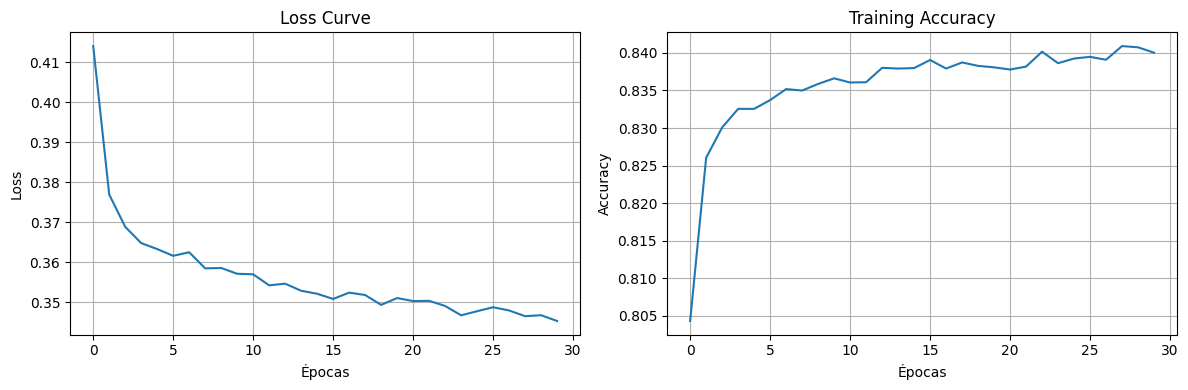

283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step - accuracy: 0.8417 - loss: 0.3432


In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.ckpt',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    x_train, y_train,
    epochs=30,
    batch_size=32,
    verbose=1,
    validation_split=0.15,
    callback=[checkpoint]
)

plt.figure(figsize=(12, 4))

# Graficar loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.title("Loss Curve")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.grid()

# Graficar accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.title("Training Accuracy")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.grid()

plt.tight_layout()
plt.show()

model.evaluate(x_test, y_test)
model.save('mpl_model.keras')

Ahora para hacer una pruebas realista, se creara un ejemplo de una persona ficticia, con información necesaria para poder realizar una predicción de un dato nuevo para el modelo.

In [ ]:
# ...existing code...
test = pd.DataFrame({
    "age": [32],
    "workclass": ["Private"],
    "education": ["Masters"],
    "educational-num": [10],
    "marital-status": ["Never-married"],
    "occupation": ["Tech-support"],
    "race": ["White"],
    "gender": ["Male"],
    "capital-gain": [0],
    "capital-loss": [0],
    "hours-per-week": [40],
    "native-country": ["Guatemala"]
})

test = test.reindex(columns=x.columns, fill_value=np.nan)
X_new_proc = preprocessor.transform(test)
result = model.predict(X_new_proc)
print(f"Predicción: {result[0][0]:.2%} de probabilidades que gane más de 50K")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Predicción: 19.05% de probabilidades que gane más de 50K


# Análisis de resultados

